In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcdefaults()
import quandl
import pandas as pd
import numpy as np
import functools
import statistics
import math
import os
from datetime import datetime, timedelta
import smtplib
import ssl
from email.message import EmailMessage
import pandas_datareader.data as web
from sklearn.ensemble import GradientBoostingRegressor
quandl.ApiConfig.api_key = "v2EVM2mpJPBQrcyFbxcH"

PermissionError: [Errno 1] Operation not permitted

In [528]:
import lightgbm
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.ensemble import RandomForestClassifier

## Loading the Data. 
Here we load the FC (Fundamentals Condensed) dataset along with the QM (Quotemedia) prices dataset, the Market Value (MKTV) dataset, and the Fundamental Ratio (FR) dataset.

In [626]:
MKTV = pd.read_csv('ZACKS_MKTV.csv')
MKTV['per_end_date'] = pd.to_datetime(MKTV['per_end_date'])
MKTV = MKTV.set_index(['per_end_date', 'ticker']).sort_index()
MKTV = MKTV[['mkt_val']]
FR = pd.read_csv('FR.csv')
FR['per_end_date'] = pd.to_datetime(FR['per_end_date'])
FR = FR[['ticker', 'per_end_date', 'curr_ratio', 'non_perform_asset_tot_loan',
       'loan_loss_reserve', 'lterm_debt_cap', 'tot_debt_tot_equity',
       'gross_margin', 'oper_profit_margin', 'ebit_margin', 'ebitda_margin',
       'pretax_profit_margin', 'profit_margin', 'free_cash_flow', 'loss_ratio',
       'exp_ratio', 'comb_ratio', 'asset_turn', 'invty_turn', 'rcv_turn',
       'day_sale_rcv', 'ret_equity', 'ret_tang_equity', 'ret_asset',
       'ret_invst', 'free_cash_flow_per_share', 'book_val_per_share',
       'oper_cash_flow_per_share']]
FR = FR.dropna(how = 'all')
FR = FR.set_index(['per_end_date', 'ticker']).sort_index()
MKTV = pd.merge(FR, MKTV, left_on=['per_end_date', 'ticker'], right_on=['per_end_date', 'ticker'], how='left')

In [741]:
FC = pd.read_csv("ZACKS_FC_2.csv")
FC = FC.set_index('per_end_date').sort_index()
FC = FC[FC['per_type'] == 'Q']
FC.index = pd.to_datetime(FC.index)
FC1 = FC.set_index([FC.index, 'ticker'])
merged = pd.merge(FC1, MKTV, left_on=['per_end_date', 'ticker'], right_on=['per_end_date', 'ticker'], how='left')
FC = merged.reset_index().set_index('per_end_date').sort_index()
FC['mkt_val'] = FC.groupby('ticker')['mkt_val'].ffill()

/var/folders/96/dxthw9ns78qfsm1htv4wnqyc0000gn/T/ipykernel_1018/42078162.py:1: DtypeWarning: Columns (4,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,44,45,46,47,49,50,51,52,53,54,55,56,57,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  FC = pd.read_csv("ZACKS_FC_2.csv")


In [3]:
QM = pd.read_csv('QUOTEMEDIA_PRICES.csv')
QM = QM.set_index('date')
QM.index = pd.to_datetime(QM.index)
QM = QM[['ticker', 'adj_close']]
QM = QM.sort_index()
QM['date'] = QM.index
QM = QM.set_index(['date', 'ticker'])

In [62]:
spy = QM.xs('SPY', level = 'ticker')

In [4]:
ticker = FC['ticker'].unique()
dic = {}
nanticks = []
for tick in ticker:
    try:
        dic[tick] = QM.xs(tick, level = 'ticker')
    except:
        nanticks.append(tick)
dic['SPY'] = spy

In [20]:
import time
def get_returns(ticker, date, window):
    start_date = pd.to_datetime(date)
    end_date = start_date + pd.Timedelta(days = window)
    try:
        price1 = float(dic[ticker].loc[start_date]['adj_close'])
        price2 = float(dic[ticker].loc[end_date]['adj_close'])
        return (price2 - price1)/price1
    except:
        return np.nan                       

In [928]:
FC_train1 = FC.loc['2010-01-01':]
ticker = FC_train1['ticker']
filing = FC_train1['filing_date']
sector = FC_train1['zacks_sector_code']
FC_train1 = FC_train1.select_dtypes(exclude=['object'])
FC_train1['ticker'] = ticker
FC_train1['filing_date'] = filing
FC_train1['sector'] = sector
FC_train1 = FC_train1.dropna(how='all', axis=1)
FC_train1 = FC_train1.dropna(subset=['filing_date']).iloc[:,9:]
FC_train1.index = pd.to_datetime(FC_train1['filing_date'])
na_percentages = FC_train1.isna().sum() / len(FC_train1) * 100
FC_train1 = FC_train1.loc[:, na_percentages <= 30]
na_percentages = FC_train1.isna().sum(axis=1) / len(FC_train1.columns) * 100
FC_train1 = FC_train1.loc[na_percentages <= 30]
float_cols = FC_train1.select_dtypes(include=['float']).columns
FC_train1[float_cols] = FC_train1[float_cols].fillna(0)
FC_train1 = FC_train1.dropna().sort_index()
FC_train1 = FC_train1[FC_train1['mkt_val'] > 1000]

In [930]:
FC_train1['1moSpy'] = FC_train1.apply(lambda x: get_returns('SPY', x.name, 28*3), axis = 1) ## delete when not doing this
FC_train1['1moReturn'] = FC_train1.apply(lambda x: get_returns(x['ticker'], x.name, 28*3), axis=1)

In [931]:
FC_train1['lastMoReturn'] = FC_train1.apply(lambda x: get_returns(x['ticker'], x.name, -28), axis = 1)
FC_train1['lastWeekReturn'] = FC_train1.apply(lambda x: get_returns(x['ticker'], x.name, -7), axis = 1)

In [932]:
FC_train1['lastweekSPY'] = FC_train1.apply(lambda x: get_returns('SPY', x.name, -7), axis = 1)
FC_train1['lastMoSPY'] = FC_train1.apply(lambda x: get_returns('SPY', x.name, -28), axis = 1)

In [979]:
FC_train1 = FC_train1.dropna()
FC_train1['Y'] = (FC_train1['1moReturn'] - FC_train1['1moSpy'])
FC_train1['Y'] = np.where(FC_train1['Y'] >=0.02, 1, np.where(FC_train1['Y'] <= -0.05, -1, 0))
label = FC_train1['Y']
trainset = FC_train1#= FC_train1.drop(['1moSpy', 'filing_date', 'ticker', 'sector'], axis = 1)
trainset = trainset.drop(['1moSpy', 'filing_date', 'ticker', 'sector'], axis = 1)

,nbr_shares_out,tot_revnu,cost_good_sold,gross_profit,tot_sell_gen_admin_exp,tot_oper_exp,oper_income,tot_non_oper_income_exp,pre_tax_income,tot_provsn_income_tax,...,ticker,filing_date,sector,1moSpy,1moReturn,lastMoReturn,lastWeekReturn,lastweekSPY,lastMoSPY,Y
filing_date,,,,,,,,,,,,,,,,,,,,,
2010-03-17,1.004816e+08,237.135,33.073,204.0620,83.608,213.391,23.7440,-3.953,19.791,-19.576,...,MENT,2010-03-17,10.0,-0.090615,0.033294,0.015458,-0.021403,-0.018190,-0.058412,1
2010-03-17,1.004816e+08,237.135,33.073,204.0620,83.608,213.391,23.7440,-3.953,19.791,-19.576,...,MENT,2010-03-17,10.0,-0.090615,0.033294,0.015458,-0.021403,-0.018190,-0.058412,1
2010-04-08,1.461641e+08,179.919,78.245,101.6740,54.672,148.054,31.8650,-0.449,31.416,12.946,...,MDRX,2010-04-08,16.0,-0.130686,-0.235012,-0.055156,-0.078657,-0.008167,-0.031960,-1
2010-04-19,4.804173e+07,195.356,15.921,179.4350,102.417,118.338,77.0180,0.000,77.018,24.282,...,BOH,2010-04-19,13.0,-0.094037,-0.031205,-0.115475,-0.064415,-0.000584,-0.026876,1
2010-04-19,3.503034e+09,2491.000,902.000,1589.0000,729.000,1859.000,632.0000,-131.000,501.000,196.000,...,CSX,2010-04-19,15.0,-0.094037,-0.027532,-0.044280,-0.024354,-0.000584,-0.026876,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-28,4.464401e+08,1733.000,1474.400,258.6000,151.900,1652.200,80.7999,-27.400,53.400,42.700,...,FTI,2022-10-28,12.0,0.022363,0.279961,-0.168959,0.060904,-0.037864,-0.081847,1
2022-10-28,1.020165e+10,127101.000,70268.000,56833.0000,34658.000,124576.000,2525.0000,419.000,2944.000,69.000,...,AMZN,2022-10-28,3.0,0.022363,-0.057304,0.092738,0.153854,-0.037864,-0.081847,-1
2022-10-28,4.762997e+07,206.687,108.621,98.0660,32.764,172.980,33.7070,1.368,35.075,10.193,...,COHU,2022-10-28,10.0,0.022363,0.051990,-0.234106,-0.121806,-0.037864,-0.081847,1


In [980]:
trainset.to_csv('ALL_DATA.csv', index = True)

## Optuna HyperParameter Selection

In [976]:
def optuna_backtest_end_return(params):
    training = trainset.loc['2011-02-15':'2016-02-15'].drop(['Y', '1moReturn'], axis = 1)
    y = trainset.loc['2011-02-15':'2016-02-15']['Y']
    clf = GradientBoostingClassifier(**params)
    clf.fit(training, y)
    validation = trainset.loc['2016-05-16':'2017-05-15'].drop(['Y', '1moReturn'], axis = 1)
    validation_y = trainset.loc['2016-05-16':'2017-05-15']['1moReturn']
    preds = clf.predict(validation)
    profit = (preds * validation_y).sum()
    positions = np.sum(np.abs(preds))
    return profit/positions

def optuna_backtest_accuracy(params):
    training = trainset.loc['2011-02-15':'2016-02-15'].drop(['Y', '1moReturn'], axis = 1)
    y = trainset.loc['2011-02-15':'2016-02-15']['Y']
    clf = GradientBoostingClassifier(**params)
    clf.fit(training, y)
    validation = trainset.loc['2016-05-16':'2017-05-15'].drop(['Y', '1moReturn'], axis = 1)
    validation_y = trainset.loc['2016-05-16':'2017-05-15']['1moReturn']
    preds = clf.predict(validation)
    positions = np.sum(np.abs(preds))
    return (np.sign(preds) == np.sign(validation_y)).sum()/ positions

def optuna_backtest_sharpe(params):
    training = trainset.loc['2011-02-15':'2016-02-15'].drop(['Y', '1moReturn'], axis = 1)
    y = trainset.loc['2011-02-15':'2016-02-15']['Y']
    clf = GradientBoostingClassifier(**params)
    clf.fit(training, y)
    validation = trainset.loc['2016-05-16':'2017-05-15'].drop(['Y', '1moReturn'], axis = 1)
    validation_y = trainset.loc['2016-05-16':'2017-05-15']['1moReturn']
    preds = clf.predict(validation)
    positions = np.sum(np.abs(preds))
    returns = preds * validation_y
    sharpe = (returns.mean() / returns.std()) * np.sqrt(len(returns)/365*2)
    return sharpe


# Use Optuna to find Optimal Hyperparameters

In [ ]:
import optuna
from optuna.trial import Trial

def objective(trial:Trial):
    t_num_trees = trial.suggest_int('n_estimators', 1, 8, step=1)
    t_learning_rate = trial.suggest_float('learning_rate', 0.5, 1, step=0.1)
    t_max_depth = trial.suggest_int('max_depth', 1, 5, step=1)
    t_min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    t_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, step=1)    
    params = {'n_estimators': t_num_trees,
              'learning_rate': t_learning_rate,
              'max_depth': t_max_depth,
              'min_samples_split': t_min_samples_split,
              'min_samples_leaf': t_min_samples_leaf,
             'random_state': 123}    
    returns = optuna_backtest_end_return(params)
    print(returns)
    return returns

study = optuna.create_study(direction = "maximize")
from functools import partial
objective_with_args = partial(objective)
study.optimize(objective_with_args, n_trials=40)
best_params_ret = study.best_params

In [ ]:
def objective(trial:Trial):
    t_num_trees = trial.suggest_int('n_estimators', 1, 8, step=1)
    t_learning_rate = trial.suggest_float('learning_rate', 0.5, 1, step=0.1)
    t_max_depth = trial.suggest_int('max_depth', 1, 5, step=1)
    t_min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    t_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, step=1)    
    params = {'n_estimators': t_num_trees,
              'learning_rate': t_learning_rate,
              'max_depth': t_max_depth,
              'min_samples_split': t_min_samples_split,
              'min_samples_leaf': t_min_samples_leaf,
             'random_state': 123}    
    accuracy = optuna_backtest_accuracy(params)
    print(accuracy)
    return accuracy

study = optuna.create_study(direction = "maximize")
objective_with_args = partial(objective)
study.optimize(objective_with_args, n_trials=40)
best_params_acc = study.best_params

In [ ]:
def objective(trial:Trial):
    t_num_trees = trial.suggest_int('n_estimators', 1, 8, step=1)
    t_learning_rate = trial.suggest_float('learning_rate', 0.5, 1, step=0.1)
    t_max_depth = trial.suggest_int('max_depth', 1, 5, step=1)
    t_min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    t_min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5, step=1)    
    params = {'n_estimators': t_num_trees,
              'learning_rate': t_learning_rate,
              'max_depth': t_max_depth,
              'min_samples_split': t_min_samples_split,
              'min_samples_leaf': t_min_samples_leaf,
             'random_state': 123}    
    sharpe = optuna_backtest_sharpe(params)
    print(sharpe)
    return sharpe

study = optuna.create_study(direction = "maximize")
objective_with_args = partial(objective)
study.optimize(objective_with_args, n_trials=40)
best_params_sharpe = study.best_params

# Backtest different Parameters (The Old Way Pre-Meeting with Victor)

In [939]:
best_params = {'n_estimators': 6,
 'learning_rate': 0.6,
 'max_depth': 4,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'random_state': 123}

def backtest(start_date, params, clfr):
    if clfr == 'g':
        clf = GradientBoostingClassifier(**params)
    elif clfr == 'r':
        clf = RandomForestClassifier(**params)
    start_date = pd.to_datetime(start_date)
    backtester = pd.DataFrame()
    pnls = []
    indices = [start_date]
    P_L = []
    x = [1]
    for i in range(24):
        end_date1 = start_date + pd.Timedelta(days = 91*2)
        start_date2 = end_date1 + pd.Timedelta(days = 7)
        end_date2 = start_date2 + pd.Timedelta(days = 28)
        training = trainset.loc[start_date:end_date1].drop(['Y', '1moReturn'], axis = 1)
        y = trainset.loc[start_date:end_date1]['Y']
        testset = trainset.loc[start_date2:end_date2].drop(['Y', '1moReturn'], axis = 1)
        y_true = trainset.loc[start_date2:end_date2]['1moReturn']
        clf.fit(training,y)
        preds = clf.predict(testset)
        profit = (preds * y_true).sum()
        pnls.append(profit)
        positions = np.sum(np.abs(preds))
        indices.append(end_date2)
        start_date = end_date1 + pd.Timedelta(days = 7)
        if positions != 0:
            x.append(x[i] + (x[i]/positions) * profit)
        else:
            x.append(x[-1])
    backtester.index = indices
    backtester['Returns'] = x
    return backtester

def backtest2(start_date, params, clfr):
    
    if clfr == 'g':
        clf = GradientBoostingClassifier(**params)
    elif clfr == 'r':
        clf = RandomForestClassifier(**params)
    start_date = pd.to_datetime(start_date)
    backtester = pd.DataFrame()
    pnls = [0]
    indices = [start_date]
    P_L = []
    x = [1]
    position = [0]
    end_date2 = pd.to_datetime(start_date)
    i = 0
    
    while end_date2 < pd.to_datetime('2022-06-01'):
        end_date1 = start_date + pd.Timedelta(days = 91*2)
        start_date2 = end_date1 + pd.Timedelta(days = 7)
        end_date2 = start_date2 + pd.Timedelta(days = 28)
        training = trainset.loc[start_date:end_date1].drop(['Y', '1moReturn'], axis = 1)
        y = trainset.loc[start_date:end_date1]['Y']
        testset = trainset.loc[start_date2:end_date2].drop(['Y', '1moReturn'], axis = 1)
        y_true = trainset.loc[start_date2:end_date2]['1moReturn']
        clf.fit(training,y)
        preds = clf.predict(testset)
        profit = (preds * y_true).sum()
        pnls.append(profit)
        positions = np.sum(np.abs(preds))
        position.append(positions)
        indices.append(end_date2)
        start_date = start_date + pd.Timedelta(days = 28)
        if positions != 0:
            x.append(x[i] + (x[i]/positions) * profit)
        else:
            x.append(x[-1])
        i = i + 1
    backtester.index = indices
    backtester['Returns'] = x
    backtester['Positions'] = position
    backtester['PnL'] = pnls
    return backtester

b = backtest('2012-02-15', best_params, 'g')
b['Returns'].plot()

#a = backtest('2010-02-15', best_params, 'g')
#a.plot()
#plt.title('Cumulative Returns from Gradient Boosting Strategy')
#plt.ylabel('Percent Returns')
#plt.show()

KeyError: "['1moReturn', 'ticker'] not found in axis"

In [842]:
strategy_mean_ret = ((pd.DataFrame(b)- 1).diff().mean()*13)
strategy_std = ((pd.DataFrame(b) - 1).diff().std()*np.sqrt(13))
strategy_sr = float((strategy_mean_ret/strategy_std).iloc[0])
print('Sharpe Ratio: ',strategy_sr)

Sharpe Ratio:  1.0938785423185562


In [944]:
b[['Returns']].head(20)

,Returns
2012-02-15,1.000000
2012-09-19,0.974773
2012-10-17,1.009709
2012-11-14,0.977206
2012-12-12,1.037012
2013-01-09,1.021676
2013-02-06,1.046445
2013-03-06,1.129070
2013-04-03,1.221772
2013-05-01,1.226311


<AxesSubplot:>

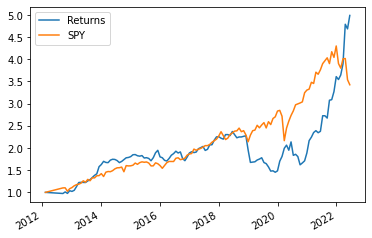

In [898]:
def add_spy(df):
    spys = []
    for index in df.index:
        spy = dic['SPY'].loc[index:].iloc[0,0]
        spys.append(spy)
    df['SPY'] = spys
    df['SPY'] = df['SPY'] / df['SPY'].tolist()[0]
    return df
b = add_spy(b)
b[['Returns', 'SPY']].plot()